## Task : Build ResNet and see it's performance on the signs dataset

In [1]:
import numpy as np
import keras
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
import matplotlib.pyplot as plt
%matplotlib inline
%config Completer.use_jedi = False

/home/happyape/.local/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


### **Before we jump to Res Nets directly, let's get a brief idea of why do they exist, how are they different from our traditional neural nets and conv nets and how they propose a better solution to the exploding/vanishing gradient problem**



**The need of deep neural networks** is that they can represent very complex functions, they can learn features at many different levels and can understand complex level features pretty smoothly

#### **The problem with the very deep neural nets** 
* As the network gets deeper and deeper, there is a huge barrier to training them, which is vanishing gradients, where the gradient signal goes to zero quickly which makes the gradient descent prohibitively slow
* More specifically, during gradient descent, as you backprop from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode" to take very large values). 

The plot below hshows that the magnitude (norm) of gradient for shallower layers decrease to zero very rapidly as training proceeds : 

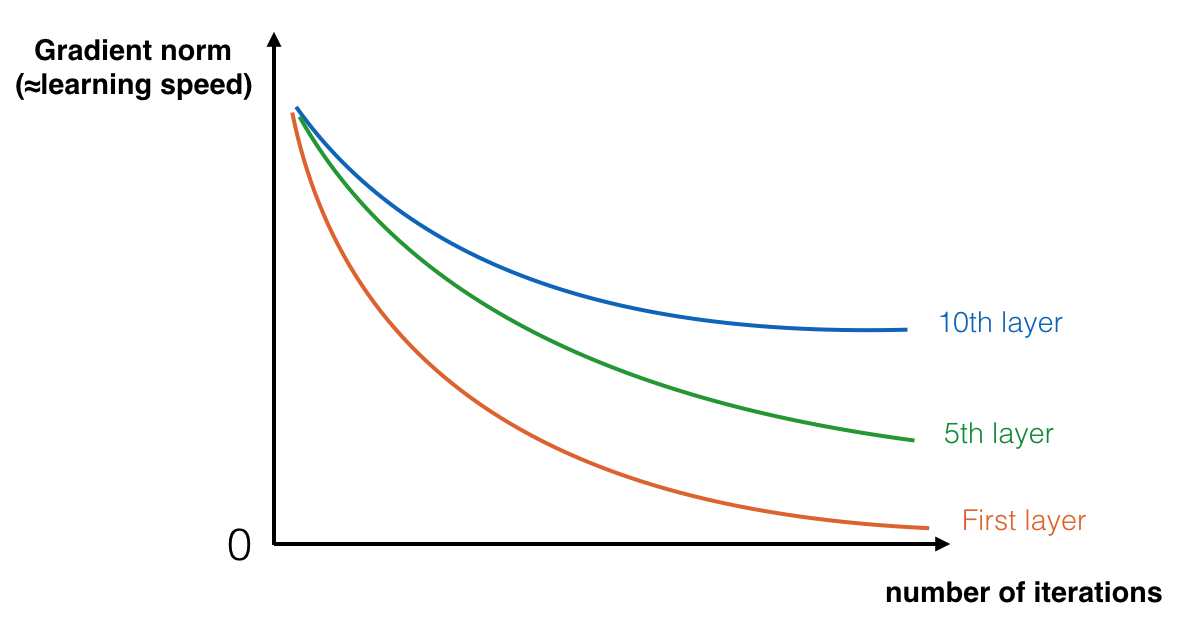

### Building Residual Networks

ResNets proposes a solution to resolve this exploding/vanishing gradient problem by using **"shortcut"** or a **"skip connection"** among intervals in layers

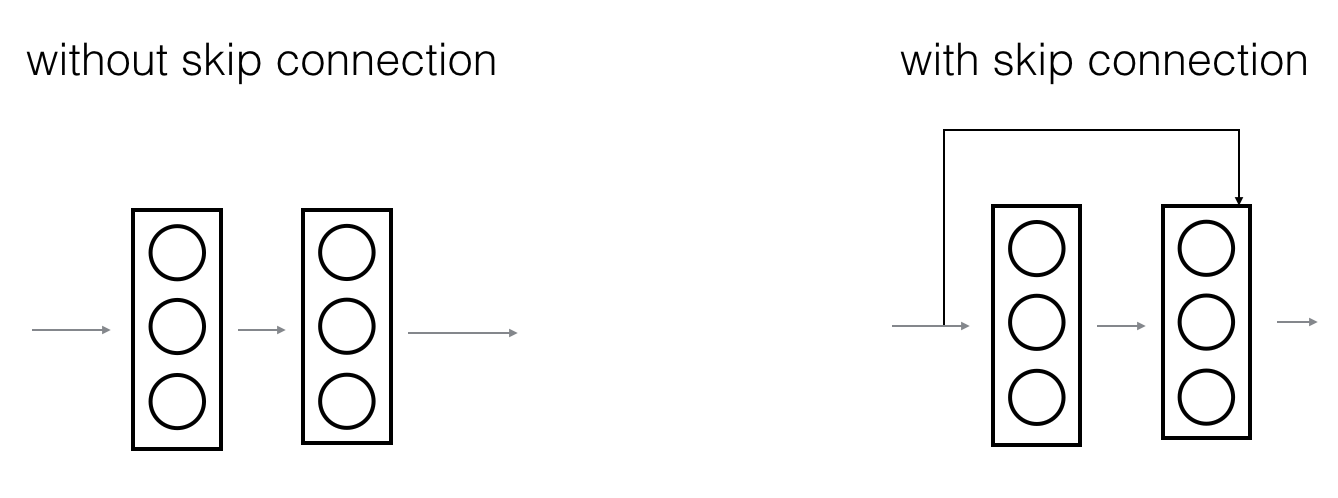

The image on the left shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, we can form a very deep network.

Also, Having ResNet Blocks with shortcut also makes it very easy for one of blocks to learn an identity function. This means that we can stack no additional ResNet blocks with little risk of harming training set performance

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are same or different. We will implement both of them: the **"identity block"** and the **"convolutional block."**

### Identity Block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps:


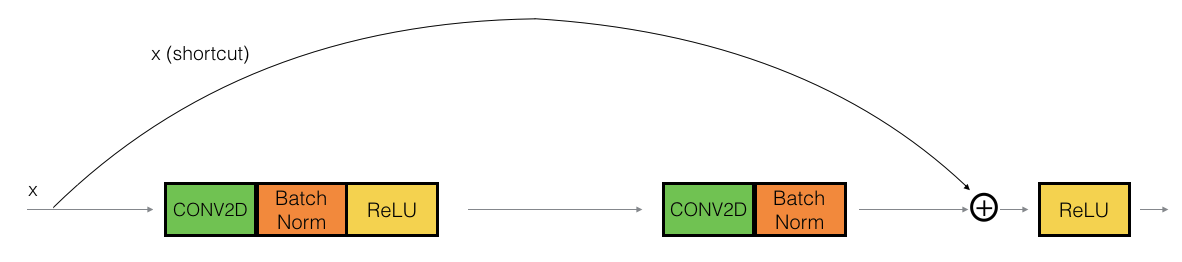


The upper path is the "shortcut path." The lower path is the "main path." In this diagram, we have also made explicit the CONV2D and ReLU steps in each layer. To speed up training we have also added a BatchNorm step.

We can even have identity block to skip over 3 hidden layers rather than 2 layers!

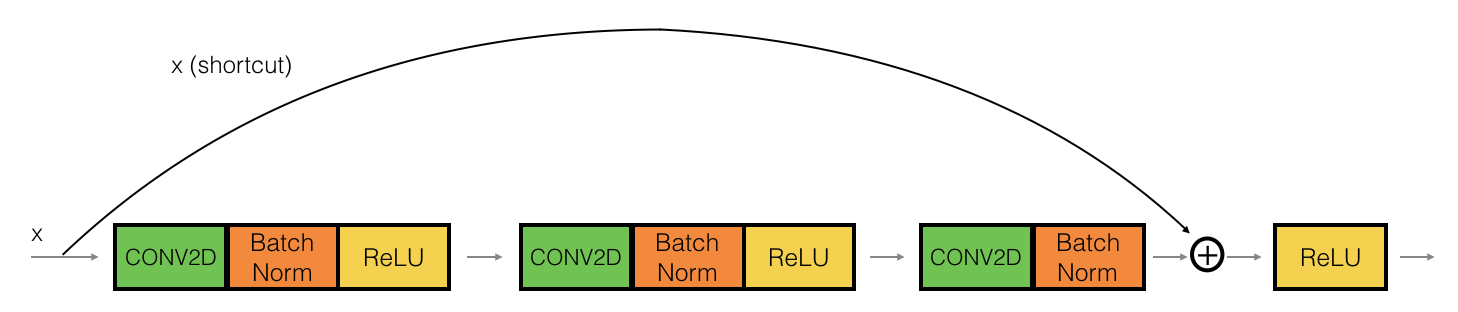

### The convolutional Block

The ResNet "convolutional block" is the second block type. we use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path:

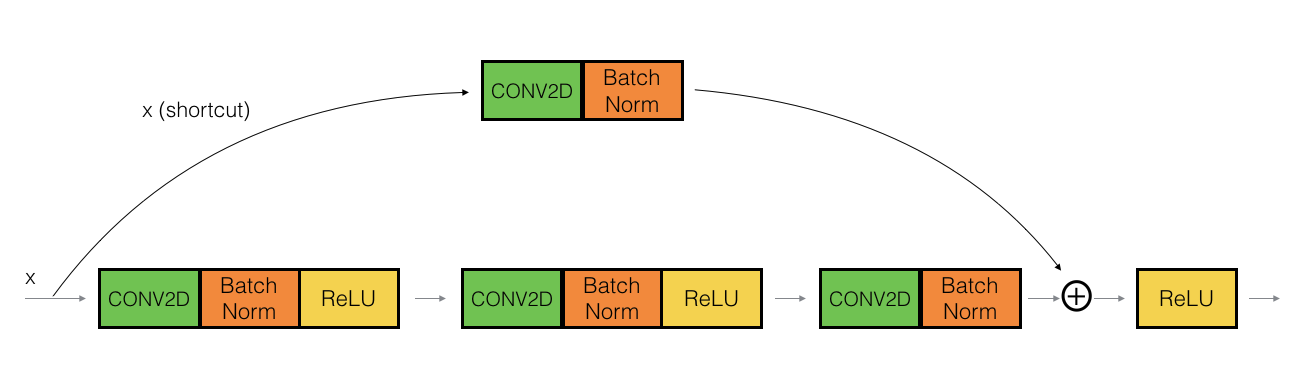



 * The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. (This plays a similar role as the matrix $W_s$ discussed in lecture.)
 
 
 * For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2.
  
 
 * The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step.


In [2]:
# Let's build identity block first

In [3]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input

In [4]:
def identity_block(X,f,filters,stage,block) : 
    
    '''
    we will be getting following details in Input : 
    
    X - input of shape (m,nH_prev,nW_prev,nC_prev)
    f - integer representing shape of middle conv's window for main path
    filters - number of filters in conv layers in main path as a list
    stage - integer counter used for naming of layers
    block - string/char use for naming of layers
    
    '''
    
    # Defining names
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Getting those filters
    F1,F2,F3 = filters
    
    # Saving the input value as we need it to add in the main path at the end
    X_shortcut = X
    
    ## First part of main path
    
    # conv2d layer of filter size (1,1) with stride 1 , padding as valid, named as with '2a' in end, and F1 filters
    # with a random initialization (xavier) from uniform distribution
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a',
               kernel_initializer=keras.initializers.glorot_uniform(seed =0))(X)
    
    # Batch Normalization layer normalizing the channels axis (which this time is 3rd) as we 
    #set K.set_image_data_format('channels_last') for input generated
    X = BatchNormalization(axis = 3,name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ## Second part of main path
    
    # Conv2d layer this time with filter size of (f,f) and F2 filters and same padding
    X = Conv2D(filters = F2, kernel_size=(f,f), strides= (1,1), padding = 'same' , name = conv_name_base + '2b', 
              kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3,name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    ## Third part of main path
    
    # Conv2d again with (1,1) filter size but F3 filter count
    X = Conv2D(filters = F3,kernel_size=(1,1),strides = (1,1),padding = 'valid', name = conv_name_base + '2c',
              kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3,name = bn_name_base + '2c')(X)
    
    # No Activation this time as we need to establish a skip connection from a[l] to a[l+3]
    # Adding shortcut value to main paht, and then passing it through the RELU activation
    
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    return X

In [5]:
# sample run
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = identity_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

Instructions for updating:
non-resource variables are not supported in the long term
out = [0.        0.        1.3454674 2.031818  0.        1.3246754]


### Let's now implement convolutional block

In [16]:
def convolutional_block(X,f,filters,stage,block,s=2) : 
    '''
    we will be getting following details in Input : 
    
    X - input of shape (m,nH_prev,nW_prev,nC_prev)
    f - integer representing shape of middle conv's window for main path
    filters - number of filters in conv layers in main path as a list
    stage - integer counter used for naming of layers
    block - string/char use for naming of layers
    s - stride value
    '''
        
    # Defining naming head patter of layers
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Getting Filters
    F1,F2,F3 = filters
    
    # Saving the input X , which will be used later
    X_shortcut = X
    
    ### Main Path
    
    ## First part
    X = Conv2D(filters = F1, kernel_size=(1,1),strides = (s,s), padding = 'valid',name = conv_name_base + '2a',
               kernel_initializer=keras.initializers.glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3,name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ## Second part
    
    X = Conv2D(filters = F2, kernel_size=(f,f),strides = (1,1), padding = 'same',name = conv_name_base + '2b',
               kernel_initializer=keras.initializers.glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3,name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    ## Third part
    
    X = Conv2D(filters = F3, kernel_size=(1,1),strides = (1,1), padding = 'valid',name = conv_name_base + '2c',
               kernel_initializer=keras.initializers.glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3,name = bn_name_base + '2c')(X)

    ### We won't be adding activation to last step of main path as we first make a shortcut
    
    ### Shortcut Path
    # In convolutional block implementation we need to have a conv and bn layer
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    
    ### Finally adding shortcut to main path
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    return X

In [17]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = convolutional_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [0.         0.         0.         0.8929657  0.         0.19882731]


## Building a 50 layer ResNet model

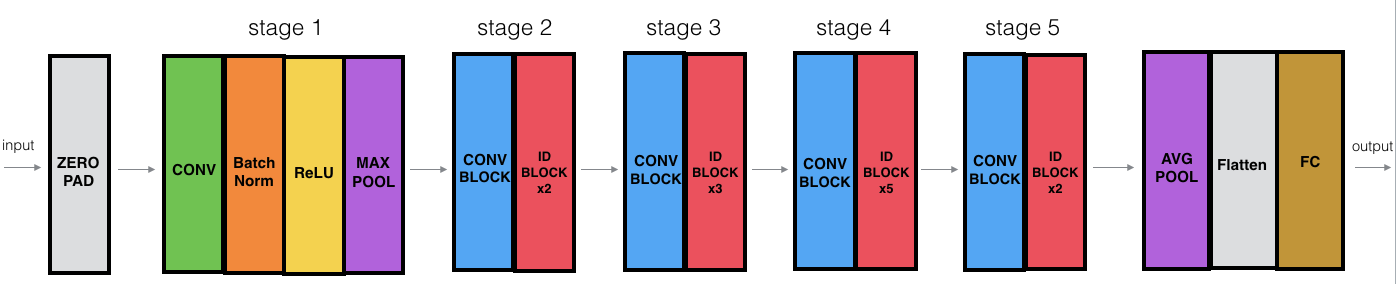

The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

The details of this ResNet-50 model are:

   * Zero-padding pads the input with a pad of (3,3)


   * **Stage 1:**
   
       1. The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). Its name is "conv1".
       
       2. BatchNorm is applied to the 'channels' axis of the input.
       
       3. MaxPooling uses a (3,3) window and a (2,2) stride.
       
       
   * **Stage 2:**
       1. The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, "s" is 1 and the block is "a".
       
       2. The 2 identity blocks use three sets of filters of size [64,64,256], "f" is 3 and the blocks are "b" and "c".
  
  
  
   * **Stage 3:**
       
       1. The convolutional block uses three sets of filters of size [128,128,512], "f" is 3, "s" is 2 and the block is "a".
       
       2. The 3 identity blocks use three sets of filters of size [128,128,512], "f" is 3 and the blocks are "b", "c" and "d".
      
      
   * **Stage 4:**
       
       1. The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3, "s" is 2 and the block is "a".
       
       2. The 5 identity blocks use three sets of filters of size [256, 256, 1024], "f" is 3 and the blocks are "b", "c", "d", "e" and "f".
   
   
   
   * **Stage 5:**
      
      1. The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3, "s" is 2 and the block is "a".
      
      2. The 2 identity blocks use three sets of filters of size [512, 512, 2048], "f" is 3 and the blocks are "b" and "c".
   
 
 
 * The 2D Average Pooling uses a window of shape (2,2) and its name is "avg_pool".
 
 
 
 * The 'flatten' layer doesn't have any hyperparameters or name.
   
 
 * The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation. Its name should be 'fc' + str(classes).


In [18]:
def ResNet50(input_shape = (64,64,3), classes = 6) : 
    
    '''
    Model : 
    
    Input -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER
    '''
    # Initializing the input tensor with given shape
    X_input = Input(input_shape)
    
    # Padding with them zeros
    X = ZeroPadding2D((3,3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3 : 
    
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # Average Pooling
    
    X = AveragePooling2D((2,2),name ='avg_pool')(X)
    
    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation = 'softmax',name = 'fc' + str(classes),
              kernel_initializer=keras.initializers.glorot_uniform(seed = 0))(X)
    
    # Create the instance of model
    model = Model(inputs = X_input,outputs = X,name = 'ResNet50')
    
    return model    

In [19]:
# instance
model = ResNet50(input_shape = (64, 64, 3), classes = 6)

In [20]:
# compiling the model
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

Now the model is ready to be trained, let's now load the dataset

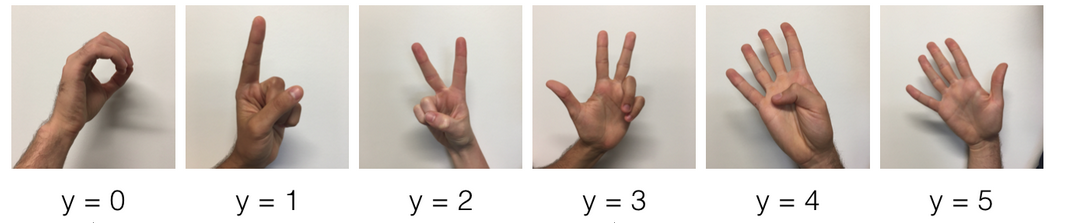

In [21]:
import h5py
import math
import os
import tensorflow as tf

In [23]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [24]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


In [25]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

In [28]:
# fitting the model
model.fit(X_train,Y_train,epochs = 20,batch_size = 32)

Train on 1080 samples
Epoch 1/20
1080/1080 [==============================] - 30s 28ms/sample - loss: 0.6670 - acc: 0.8139
Epoch 2/20
1080/1080 [==============================] - 36s 34ms/sample - loss: 0.3775 - acc: 0.8861
Epoch 3/20
1080/1080 [==============================] - 36s 33ms/sample - loss: 0.3032 - acc: 0.9213
Epoch 4/20
1080/1080 [==============================] - 40s 37ms/sample - loss: 0.2845 - acc: 0.9296
Epoch 5/20
1080/1080 [==============================] - 44s 41ms/sample - loss: 0.2214 - acc: 0.9444
Epoch 6/20
1080/1080 [==============================] - 37s 34ms/sample - loss: 0.6041 - acc: 0.8435
Epoch 7/20
1080/1080 [==============================] - 36s 34ms/sample - loss: 0.5876 - acc: 0.8231
Epoch 8/20
1080/1080 [==============================] - 42s 39ms/sample - loss: 0.4208 - acc: 0.8963
Epoch 9/20
1080/1080 [==============================] - 40s 37ms/sample - loss: 0.3487 - acc: 0.9093
Epoch 10/20
1080/1080 [==============================] - 43s 39ms/sam

In [29]:
preds = model.evaluate(X_train,Y_train)
print('Loss =' +  str(preds[0]))
print("Accuracy = " + str(preds[1]))

Loss =0.03774055818837412
Accuracy = 0.9861111


In [43]:
## woah! Our 50 layer ResNet performed extremely great over just 20 epochs

Image shape :  (1, 64, 64, 3)
class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
[1.7969125e-04 9.2660201e-05 4.8638758e-06 9.8619545e-01 1.3103767e-02
 4.2355567e-04]
------
Finally : 
Probability / Confidence : 0.98619545
Number predicted : 3


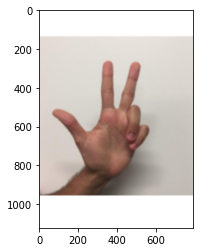

In [52]:
from keras.preprocessing import image
import scipy
from PIL import Image
from scipy import ndimage
import imageio


img_path = 'images/3.jpg'
img = image.load_img(img_path , target_size=(64,64))
x = image.img_to_array(img)
x = np.expand_dims(x,axis =0)
x = x/255.0
print("Image shape : ", x.shape)
img = imageio.imread(img_path)
plt.imshow(img)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
result = model.predict(x)[0]
print(result)
print('------')
print("Finally : ")
print("Probability / Confidence : " + str(max(result)))
print("Number predicted : "  + str(np.argmax(result)))


Image shape :  (1, 64, 64, 3)
class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
[3.1392457e-08 6.3378522e-14 1.2568608e-12 9.9047357e-01 9.5262714e-03
 1.5262425e-07]
------
Finally : 
Probability / Confidence : 0.99047357
Number predicted : 3


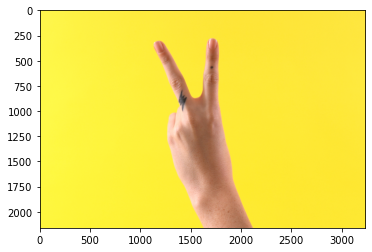

In [53]:
img_path = 'images/2.jpeg'
img = image.load_img(img_path , target_size=(64,64))
x = image.img_to_array(img)
x = np.expand_dims(x,axis =0)
x = x/255.0
print("Image shape : ", x.shape)
img = imageio.imread(img_path)
plt.imshow(img)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
result = model.predict(x)[0]
print(result)
print('------')
print("Finally : ")
print("Probability / Confidence : " + str(max(result)))
print("Number predicted : "  + str(np.argmax(result)))


Umm.. that's a 2 my model...

### Here is the model summary

In [54]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________